# LSTM - Long-Short-Term-Menory
## Architecture
输入： 当前序列输入$x$、上一时间步的cell state $c_{t-1}$、上一时间步的隐状态$h_{t-1}$

输出： 当前时间步的cell state $c_{t}$、当前时间步的隐状态$h_{t}$

- 忘记门：将值朝0减少，忘掉过去的状态，看现在的状态
- 输入门：决定是不是忽略掉输入
- 输出门：决定是不是使用隐状态

公式分别为：
$$I_t=\sigma(X_tW_{xi}+H_{t-1}W_{hi}+b_i)$$
$$F_t=\sigma(X_tW_{xf}+H_{t-1}W_{hf}+b_f)$$
$$O_t=\sigma(X_tW_{xo}+H_{t-1}W_{ho}+b_o)$$
候选记忆单元：
$$\tilde {C}_t=\sigma(X_tW_{xc}+H_{t-1}W_{hc}+b_c)$$
记忆单元:
$$C_t=F_t \odot C_{t-1} + I_t \odot \tilde{C}_t$$
隐状态:$$H_t=O_t \odot tanh(C_t)$$

## Background - the Issue with RNNs
在训练过程中，RNN的梯度消失一直是一个无法忽略的问题，当梯度变得很小的时候，网络将不能够学习到东西。因为梯度消失问题，RNN需要很长时间才能够学习到一些很长时间段的序列信息。在RNN中，获得适当的梯度更新的网络会停止学习，这些经常是RNN的前几层，`RNN可以忘记在长序列中看到的东西，因为这些层不再学习`(什么意思？？)，这就导致了短期记忆，当遗忘的东西增加，RNN性能也就变得不可靠。如果要预测一个自然段的数据，RNN可能会遗忘在开头的重要数据。

假设我们在观看视频是回忆起之前的场景，或者是阅读一本书的时候知道前一章节发生了什么，RNN也是类似的工作方式：RNN记得先前的信息，并利用它来处理当前的输入；然而由于梯度消失的问题，RNN不能够回想起长期的记忆。

LSTM就是为了解决上述问题的，从多个角度来看，LSTM模型对于间隔长度不是很敏感，所以比RNN、传统的前馈网络、隐马尔可夫模型和其它序列学习方法更有优势。

## Applications
语言模型、图片说明、机器翻译和问答机器人等等，LSTM非常适合用来处理时间序列的数据

## ref
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [2]:
import torch as t 
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append("../")
from pltutils import *

In [4]:
batch_size,num_steps=32,35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)


In [5]:
def get_lstm_params(vocab_size:int,num_hiddens,device:t.device):
    num_inputs=num_outputs=vocab_size

    def normal(shape):
        return t.randn(size=shape,device=device)*0.01
    
    def three():
        return (
            normal((num_inputs,num_hiddens)),
            normal((num_hiddens,num_hiddens)),
            t.zeros(num_hiddens,device=device)
        )
    
    W_xi,W_hi,b_i=three()#输入门参数
    W_xf,W_hf,b_f=three()#遗忘门参数
    W_xo,W_ho,b_o=three()#输出门参数
    W_xc,W_hc,b_c=three()#候选记忆元参数
    #输出层参数
    W_hq=normal((num_hiddens,num_outputs))
    b_q=t.zeros(num_outputs,device=device)
    #附加梯度
    params=[W_xi,W_hi,b_i,W_xf,W_hf,b_f,W_xo,W_ho,b_o,W_xc,W_hc,b_c,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [6]:
def init_lstm_state(batch_size,num_hiddens,device):
    return (
        t.zeros((batch_size,num_hiddens),device=device),
        t.zeros((batch_size,num_hiddens),device=device)
    )

模型的定义与之前的一样，提供三个门和一个额外的记忆元，记忆元$\mathbf{C}_t$不直接参与计算

In [7]:
def lstm(inputs,state:tuple[torch.Tensor,torch.Tensor],params:list[torch.Tensor]):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    (H,C)=state
    outputs=[]

    for X in inputs:
        I=t.sigmoid((X@W_xi)+(H@W_hi)+b_i)
        F=t.sigmoid((X@W_xf)+(H@W_hf)+b_f)
        O = t.sigmoid((X@W_xo)+(H@W_ho)+b_o)
        C_tilda=t.tanh((X@W_xc)+(H@W_hc)+b_c)
        C=F*C+I*C_tilda
        H=O*t.tanh(C)
        Y=(H@W_hq)+b_q
        outputs.append(Y)
    return t.cat(outputs,dim=0),(H,C)

困惑度 1.3, 18707.3 词元/秒 cuda:0
time traveller of hame aracllas tording ary whiod is a mine a ra
traveller con an ming aldryed thing to exoncu out laskex of


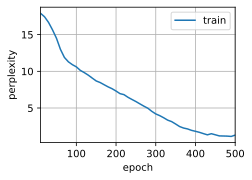

In [8]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 复习一下
## 关键公式
$$ \begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
\end{array}$$

## 关键概念
LSTM的关键概念就是cell state和多个门，cell state可以想象成这个网络的“记忆”，从理论上来讲，cell state可以在整个序列的处理过程中携带相关的信息，所以在早些时间步的信息也可以被传递到之后的时间步中，从而减少了短期记忆的影响。

在cell state前向传播的时候，信息通过门被添加到cell state中或者是从cell state中被删除，一个LSTM中有很多个门，这些门是不同的神经网络，决定哪些信息可以在细胞状态中被允许，在训练过程中，门可以学习到哪些信息是相关的，需要被保留，哪些信息需要被遗忘

## Sigmoid
门控都包含sigmoid激活函数，sigmoid激活函数类似于tanh激活函数，不同于tanh将数据缩放到[-1,1]区间，sigmoid将数据缩放到[0,1]区间，这对于更新或者遗忘数据很有帮助：任何数与0相乘都是0，导致数据消失，或者说被“遗忘”，任何数与1相乘都是它本身，导致数据被“保留”，RNN可以自己学习哪个数据是重要的，然后保留它，哪些数据是不重要的，要遗忘它。

Sigmoid函数的公式如下：
$$\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + \exp(-x)}$$

## 门控单元
### 1. 遗忘门
遗忘门决定着哪些输入信息应该被遗忘、哪些被保留，遗忘门的输出通过Sigmoid函数，越接近0代表数据被遗忘，反之数据被记住

### 2. 输入门
为了更新cell state，我们定义了`输入门`；

首先我们将隐状态和现在的输入丢到一个sigmoid函数里面去，这个函数的输出就是决定哪些数值要被`更新`

我们还要隐状态和现在的输入丢到tanh激活函数里面去缩放到[-1,1]，然后将tanh的输出和sigmoid的输出进行逐位相乘，sigmoid输出会决定tanh输出的哪些信息是重要的。

### 3. Cell State
有了遗忘门和输入门的数据，我们现在有了足够的信息去计算我们的Cell State，首先，之前的Cell State与遗忘门的向量进行点乘，如果它被接近0的值所乘，那么就会丢掉值。然后将其与输入门的输出进行逐位的相加，将cell state更新为神经网络认为的相关的新值，这样我们就得到了新的cell state

### 4. 输出门
最后我们有输出门，输出门决定了下个隐状态是什么样的，隐状态包含了之前的信息，而且还被用来进行预测，首先我们将现在的输入和之前的隐状态丢到sigmoid函数里头去，之后将新的cell state丢到tanh函数里头去，然后将tanh输出和sigmoid输出进行一个点积， 以决定隐藏状态应该携带什么信息。然后，新的cell state和新的隐藏被带到下一个时间步骤中。


To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.

LSTM神经元在时间维度上向后传递了两份信息:(1)cell state;(2)hidden state。hidden state是cell state经过一个神经元和一道“输出门”后得到的，因此hidden state里包含的记忆，实际上是cell state衰减之后的内容。另外，cell state在一个衰减较少的通道里沿时间轴传递，对时间跨度较大的信息的保持能力比hidden state要强很多。因此，实际上hidden state里存储的，主要是“近期记忆”；cell state里存储的，主要是“远期记忆”。cell state的存在，使得LSTM得以对长依赖进行很好地刻画。
https://www.zhihu.com/question/68456751